Mount το google drive. Το κάνουμε αυτό για έχουμε πρόσβαση στα python modules που χρειαζόμαστε.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Το συνδέουμε με το folder του συγκεκριμένου εργαστηρίου

### ΠΡΟΣΟΧΗ 
Eδώ έχουμε δηλώσει στο home directory στο drive (content/drive/My Drive/) να δημιουργηθεί ένα directory με το όνομα Lab_DL_ex1_2023 
 Σε αυτό το directory θα πρέπει να υπάρχουν τα εξής αρχεία:
 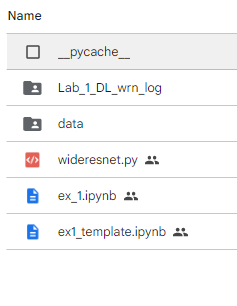

 Σε περίπτωση που θέλετε να δουλέψετε σε άλλο directory, αυτό θα πρέπει να περιέχει όλα τα αρχεία που φαίνονται παραπάνω(2 φάκελοι και 4 αρχεία)
 

In [ ]:
root_path = '/content/drive/My Drive/DL23-assignment-1/Lab_DL_ex1_2023_upd'

In [ ]:
import sys
sys.path.insert(0,root_path)

Εγκαθιστούμε τις απαραίτητες βιβλιοθήκες

In [ ]:
import sys
!{sys.executable} -m pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.10.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.10.1


In [ ]:
!{sys.executable} -m pip install matplotlip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Οδηγίες

Σε αυτή την εργασία θα κάνετε τα εξής:
1. Δοκιμή τουλάχιστον των 3 καλύτερων συνδυασμών των παραμέτρων width και depth του Δικτύου wideResNet σύμφωνα με αυτά που προτείνονται και στο paper (results with moderate data augmentation)

2. Regularization. Το δίκτυο έχει μηχανισμό ομαλοποίησης (Dropout). Δοκιμάστε να προσθέσετε το Dropout (παράμετρος droprate) όπως αναφέρει το paper και καταγράψτε τα αποτελέσματα για τα παραπάνω μοντέλα. 

3. Κρατώντας τις παραμέτρους του δικτύου με τα καλύτερα αποτελέσματα (load best model από το 1 και 2) θα κάνετε εκ νέου training με το custom Data Generator (CIFAR_Dataset) στο CIFAR-C χωρίς το mixup. Έπειτα, θα εφαρμόσετε τη μέθοδο mixup (συμπληρώστε τον κώδικα στο κελί με το CifarDataset) κάντε εκ νέου την εκπαίδευση και καταγράψτε τα αποτελέσματα (Δεν είναι η επίσημη υλοποίηση γι αυτό τα results δεν είναι αντίστοιχα του βήματος 1 και 2 και η διαφορα μεταξύ training με mixup και χωρίς mixup θα είναι πολύ μικρή ( μικρότερη απο 2%). 

4. (Bonus) Κάντε επίσης ένα plot των confidence scores (softmax predictions) και συγκρίνετε το με το αντίστοιχο plot όταν το μοντέλο δεν είχε mixup. Τι παρατηρείτε? 

Tip: Για το κάθε πείραμα (training) μην το τρέξετε πάνω από 100 εποχές


Ορισμένα κελιά κώδικα παρέχονται για εσάς σε αυτό το notebook. Θα πρέπει να αποφύγετε την επεξεργασία του παρεχόμενου κώδικα και να φροντίσετε να εκτελέσετε τα κελιά για να αποφύγετε απροσδόκητα σφάλματα. Ορισμένα κελιά ξεκινούν με τη γραμμή:

΄#### GRADED CELL ####`
Αυτά θα βαθμολογηθούν. Φρόντιστε για κάθε κελί να δικαιολογείτε με σχόλια τις επιλογές σας.


### Ας ξεκινήσουμε!

Θα ξεκινήσουμε την εκτέλεση ορισμένων imports και τη φόρτωση του συνόλου δεδομένων. Μην επεξεργαστείτε τα υπάρχοντα imports στο παρακάτω κελί. Εάν θέλετε να κάνετε περαιτέρω imports, θα πρέπει να τα προσθέσετε εδώ.

Φορτώνουμε τις απαραίτητες βιβλιοθήκες

In [ ]:
import numpy as np
import time
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from wideresnet import WideResNet
import logging
import shutil
import os
import matplotlib.pyplot as plt



torch.manual_seed(0)
np.random.seed(0)


In [ ]:
data_dir = root_path + "/data"

Δημιουργία φακέλου στο οποίο θα κρατάμε τα log files των πειραμάτων 

In [ ]:
exp_name = root_path + "/Lab_1_DL_wrn_log"


exp_dir = os.path.join('Cifar', exp_name)

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)


logfile = open(os.path.join(exp_dir, 'log'), 'w') 

Στο παρακάτω κελί θα δημιουργήσουμε το train και validation loader χρησιμοποιώντας τη συνάρτηση construct_datasets

In [ ]:
def construct_datasets(data_dir, batch_size):
    def data2loader_train(tr_data):
        train_loader = torch.utils.data.DataLoader(
            tr_data,
            batch_size=batch_size,
            shuffle=True)
        return train_loader

    def data2loader_test(te_data):
        test_loader = torch.utils.data.DataLoader(
            te_data,
            batch_size=batch_size,
            shuffle=False)

        return test_loader

    # to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(), normalize]) 

    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])

    train_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=False, transform=test_transform, download=True)
    print("Train set number of items ", len(train_data))
    print("Val set number of items ", len(test_data))

    return data2loader_train(train_data), data2loader_test(test_data)

In [ ]:
batch_size = 128
train_loader, val_loader = construct_datasets(data_dir, batch_size)

Files already downloaded and verified
Files already downloaded and verified
Train set number of items  50000
Val set number of items  10000


Σε αυτό το σημείο θα ορίσουμε το μοντέλο (Wide Residual Network), τη loss function και τον scheduler αυτής και τον optimizer

In [ ]:
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))
    
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
  
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            targets = targets.cuda(non_blocking=True).long()
            images = images.cuda(non_blocking=True).float()
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)



In [ ]:
print_freq = 5  # The notebook has a bug and it hasn't declared this variable in train_model function, declared below.

In [ ]:
def train_model(num_iters, train_loader, model):

  # Train loop

  for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()

    params = list(model.parameters())
    output = model(input)
    ce_loss = criterion(output, target)
    #ce_loss = criterion(output, target)

    
    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    scheduler.step()


      # measure accuracy and record loss
    prec1 = accuracy(output, target, topk=(1,))[0]
    losses.update(ce_loss.data.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

    global print_freq

    if t % print_freq == 0 and t >= print_freq:

        loss1, prec1 = test_cifar(val_loader, model)
        #print("Epoch ", epoch)
        print(f'Epoch: {t // len(train_loader)} - Batch: {t % len(train_loader)} -  Validation set acc: {prec1} - CE Loss: {ce_loss.data.item()}', )
        logfile.write('validation set acc: ' + str(prec1) + '\n')
        

        

  # validate_all(model, args.data_dir, exp_name, args.batch_size, logfile, t, kwargs)

  print('Cifar accuracy {}'.format(test_cifar(val_loader, model)))
  logging.info(f'avg acc {test_cifar(val_loader, model)}')
  logfile.write(str(t) + ' Val acc: ' + str(test_cifar(val_loader, model)) + '\n')
  logfile.close()





## Ζητούμενο 1 και 2.

Διαβάζοντας το paper θα πρέπει να βρείτε τις παραμέτρους (layers (depth factor, widen_factor, droprate (dropout)) για τα 3 καλύτερα μοντέλα που προτείνονται στο paper και να εκπαιδεύσετε το μοντέλο  με αυτές. 



### Απάντηση

Στον πίνακα 5 της σελίδας 8 του paper παρουσιάζονται συγκριτικά τα τρία καλύτερα WRN μοντέλα χωρίς τη χρήση κανονικοποίησης τύπου Drop Out. Αυτά είναι τα εξής:

| Ν (number of layers) | k (widening factor) |
| :--: | :--: |
| 40 | 4 |
| 16 | 8 |
| 28 | 10 |

Στην σελίδα 9, στο χωρίο με τίτλο *`Dropout in residual blocks`*, αναφέρεται χαρακτηριστικά: *`We used cross-validation to determine dropout probability values, 0.3 on CIFAR and 0.4 on SVHN`*. Εμείς μελετούμε το CIFAR dataset οπότε και το DropOut rate μας είναι ίσο με 0.3. 

Θέτουμε `epochs=10`, πράγμα που σημαίνει ότι θα εκπαιδεύσουμε το μοντέλο μας για 10 εποχές.

In [ ]:
from math import ceil
epochs = 10  # In Colab, each epoch takes ~1h to run using a GPU. The original suggestion was to run it for 100 epochs, but Colab free does not provide async running, so we will run it for 10 epochs

print(len(train_loader))

num_iters = len(train_loader) * epochs  # ceil(50000 / 128) * 10 = ceil(390.625) * 10 = 391 * 10 = 3910

print(num_iters)

391
3910


In [ ]:
#### GRADED CELL ####

logfile = open(os.path.join(exp_dir, 'log'), 'a+') 
'''
ValueError: I/O operation on closed file.
'''

# Complete the following parameters and run the cell 

# Model Parameters cell 1

layers = 40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = .3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(  
      step,
      num_iters,
      1, 
      1e-6 / lr))


train_model(num_iters, train_loader, model)


state_dict_40_4 = model.state_dict()
# print(state_dict_40_4)

torch.save(state_dict_40_4, f'{root_path}/WRN-40-4.tar')

Epoch: 0 - Batch: 5 -  Validation set acc: 0.1342 - CE Loss: 2.292712688446045
Epoch: 0 - Batch: 10 -  Validation set acc: 0.1048 - CE Loss: 2.1584601402282715
Epoch: 0 - Batch: 15 -  Validation set acc: 0.1 - CE Loss: 2.1633479595184326
Epoch: 0 - Batch: 20 -  Validation set acc: 0.106 - CE Loss: 2.1510725021362305
Epoch: 0 - Batch: 25 -  Validation set acc: 0.1502 - CE Loss: 1.9694167375564575
Epoch: 0 - Batch: 30 -  Validation set acc: 0.1691 - CE Loss: 1.995736837387085
Epoch: 0 - Batch: 35 -  Validation set acc: 0.2137 - CE Loss: 1.9214357137680054
Epoch: 0 - Batch: 40 -  Validation set acc: 0.2511 - CE Loss: 1.7970391511917114
Epoch: 0 - Batch: 45 -  Validation set acc: 0.2626 - CE Loss: 1.9229689836502075
Epoch: 0 - Batch: 50 -  Validation set acc: 0.3138 - CE Loss: 1.8426897525787354
Epoch: 0 - Batch: 55 -  Validation set acc: 0.2648 - CE Loss: 1.91989004611969
Epoch: 0 - Batch: 60 -  Validation set acc: 0.2667 - CE Loss: 1.9183615446090698
Epoch: 0 - Batch: 65 -  Validation se

In [ ]:
#### GRADED CELL ####


logfile = open(os.path.join(exp_dir, 'log'), 'a+') 
'''
ValueError: I/O operation on closed file.
'''


# Complete the following parameters and run the cell 

# Model Parameters cell 2

layers = 16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate = .3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(  
      step,
      num_iters,
      1, 
      1e-6 / lr))


train_model(num_iters, train_loader, model)

state_dict_16_8 = model.state_dict()
# print(state_dict_16_8)

torch.save(state_dict_16_8, f'{root_path}/WRN-16-8.tar')

Epoch: 0 - Batch: 5 -  Validation set acc: 0.1 - CE Loss: 2.260078191757202
Epoch: 0 - Batch: 10 -  Validation set acc: 0.1039 - CE Loss: 2.202024459838867
Epoch: 0 - Batch: 15 -  Validation set acc: 0.1402 - CE Loss: 2.0224497318267822
Epoch: 0 - Batch: 20 -  Validation set acc: 0.2136 - CE Loss: 1.9373853206634521
Epoch: 0 - Batch: 25 -  Validation set acc: 0.2516 - CE Loss: 1.958323359489441
Epoch: 0 - Batch: 30 -  Validation set acc: 0.2593 - CE Loss: 1.8259130716323853
Epoch: 0 - Batch: 35 -  Validation set acc: 0.2542 - CE Loss: 1.8408362865447998
Epoch: 0 - Batch: 40 -  Validation set acc: 0.2645 - CE Loss: 1.9826754331588745
Epoch: 0 - Batch: 45 -  Validation set acc: 0.2857 - CE Loss: 1.8897064924240112
Epoch: 0 - Batch: 50 -  Validation set acc: 0.2778 - CE Loss: 1.8638496398925781
Epoch: 0 - Batch: 55 -  Validation set acc: 0.3304 - CE Loss: 1.743584156036377
Epoch: 0 - Batch: 60 -  Validation set acc: 0.3244 - CE Loss: 1.6710487604141235
Epoch: 0 - Batch: 65 -  Validation s

In [ ]:
#### GRADED CELL ####

logfile = open(os.path.join(exp_dir, 'log'), 'a+') 
'''
ValueError: I/O operation on closed file.
'''

# Complete the following parameters and run the cell 

# Model Parameters cell 3

layers = 28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = .3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(  
      step,
      num_iters,
      1, 
      1e-6 / lr))


train_model(num_iters, train_loader, model)

state_dict_28_10 = model.state_dict()
# print(state_dict_20_10)

torch.save(state_dict_28_10, f'{root_path}/WRN-28-10.tar')

Epoch: 0 - Batch: 5 -  Validation set acc: 0.1075 - CE Loss: 2.4528849124908447
Epoch: 0 - Batch: 10 -  Validation set acc: 0.1066 - CE Loss: 2.331425428390503
Epoch: 0 - Batch: 15 -  Validation set acc: 0.1313 - CE Loss: 2.3312759399414062
Epoch: 0 - Batch: 20 -  Validation set acc: 0.2148 - CE Loss: 2.267130136489868
Epoch: 0 - Batch: 25 -  Validation set acc: 0.1916 - CE Loss: 1.9354722499847412
Epoch: 0 - Batch: 30 -  Validation set acc: 0.238 - CE Loss: 1.9702059030532837
Epoch: 0 - Batch: 35 -  Validation set acc: 0.2888 - CE Loss: 1.9682272672653198
Epoch: 0 - Batch: 40 -  Validation set acc: 0.3106 - CE Loss: 1.8347244262695312
Epoch: 0 - Batch: 45 -  Validation set acc: 0.2795 - CE Loss: 1.806727647781372
Epoch: 0 - Batch: 50 -  Validation set acc: 0.2647 - CE Loss: 1.660616159439087
Epoch: 0 - Batch: 55 -  Validation set acc: 0.2079 - CE Loss: 1.9222432374954224
Epoch: 0 - Batch: 60 -  Validation set acc: 0.2831 - CE Loss: 1.6650515794754028
Epoch: 0 - Batch: 65 -  Validation

### Σχολιασμός Αποτελεσμάτων

Στον παρακάτω πίνακα συνοψίζονται τα αποτελέσματα (CE Loss & Accuracy) για την εκπαίδευση των τριών μοντέλων για 10 εποχές.

Παρατηρούμε ότι ***Acc(*** *WRN-40-4* ***)*** < ***Acc(*** *WRN-16-8* ***)*** < ***Acc(*** *WRN-28-10* ***)***. Αν και η εκπαίδευση έγινε μόνο για 10 εποχές, τα αποτελέσματα αυτά είναι σύμφωνα ως προς την διάταξη των τριών μοντέλων ως προς την απόδοσή τους σε σχέση με την αρχική επιστημονική δημοσίευση (paper).

| Algorithm | Cross-Entropy Loss | Accuracy (Test) |
| :--: | :--: | :--: |
| WRN-40-4 | 0.002505 | 0.8916 |
| WRN-16-8 | 0.002410 | 0.8967 |
| WRN-28-10 | 0.002281 | 0.9046 |

Επαληθεύουμε λοιπόν πως το καλύτερο μοντέλο είναι το WRN-28-10 βάσει μετρικής ακρίβειας, οπότε και αυτό θα είναι το μοντέλο που θα χρησιμοποιήσουμε στην συνέχεια των πειραμάτων.

# Μέρος 3 
## WRN με Mixup augmentation στο CIFAR-C


Στις περισσότερες επιτυχημένες εφαρμογές τα νευρωνικά δίκτυα (large deep neuaral networks) μοιράζονται δύο κοινά σημεία. Πρώτον, είναι
εκπαιδευμένα ώστε να ελαχιστοποιούν το μέσο σφάλμα τους στα δεδομένα εκπαίδευσης, ένας κανόνας εκμάθησης γνωστός και Empirical Risk Minimazation (ERM) (Vapnik, 1998). Δεύτερον, το μέγεθος αυτών των νευρωνικών δικτύων  κλιμακώνεται γραμμικά με τον αριθμό των παραδειγμάτων εκπαίδευσης. 

Παραδόξως, ένα κλασικό αποτέλεσμα στη θεωρία μάθησης (Vapnik & Chervonenkis, 1971) μας λέει ότι η
η σύγκλιση του ERM είναι εγγυημένη εφόσον το μέγεθος της μηχανής εκμάθησης (π.χ.
δίκτυο) δεν αυξάνεται με τον αριθμό των δεδομένων εκπαίδευσης. Εδώ, το μέγεθος μιας μηχανής εκμάθησης μετριέται ως προς τον αριθμό των παραμέτρων του.

Αυτή η αντίφαση αμφισβητεί την καταλληλότητα του ERM να εκπαιδεύει τα τρέχοντα μοντέλα νευρωνικών δικτύων μας. Από τη μία πλευρά, ο ERM επιτρέπει σε μεγάλα νευρωνικά δίκτυα να απομνημονεύουν
(αντί να γενικεύσουμε από) τα δεδομένα εκπαίδευσης ακόμη και με την παρουσία ισχυρής ομαλοποίησης (Dropout). Επίσης, α νευρωνικά δίκτυα που έχουν εκπαιδευτεί με ERM αλλάζουν δραστικά τις προβλέψεις τους όταν αξιολογούνται
παραδείγματα με μικρές διαφορές από την κατανομή της εκπαίδευσης (adversarial examples). Αυτά τα στοιχεία υποδηλώνουν ότι ο ERM δεν είναι σε θέση να εξηγήσει ή να παράσχει γενίκευση στις δοκιμές κατανομές που διαφέρουν ελάχιστα από τα δεδομένα εκπαίδευσης. Ωστόσο, ποια είναι η εναλλακτική του ERM;

Η μέθοδος επιλογής για εκπαίδευση σε παρόμοια αλλά διαφορετικά παραδείγματα με τα δεδομένα εκπαίδευσης είναι γνωστή ως δεδομένα επάυξησης (Data augmentation) (Simard et al., 1998), Vicinal Risk Minimization (VRM)
(Chapelle et al., 2000). Στο VRM, απαιτείται ανθρώπινη γνώση για να περιγράψει μια γειτονιά γύρω από κάθε παράδειγμα στα δεδομένα εκπαίδευσης. Στη συνέχεια, μπορούν να αντληθούν πρόσθετα εικονικά παραδείγματα από το
διανομή των παραδειγμάτων εκπαίδευσης σε κοντινή απόσταση για να διευρυνθεί η υποστήριξη της κατανομής εκπαίδευσης. Για παράδειγμα, κατά την εκτέλεση ταξινόμησης εικόνων, είναι σύνηθες να ορίζεται η γειτνίαση μιας εικόνας
ως το σύνολο των οριζόντιων αντανακλάσεων, των ελαφρών περιστροφών. Ενώ η αύξηση δεδομένων οδηγεί σταθερά σε βελτιωμένη γενίκευση, η διαδικασία εξαρτάται από τα δεδομένα, και συνεπώς απαιτεί τη χρήση ειδικών γνώσεων. Επιπλέον, η αύξηση δεδομένων προϋποθέτει ότι τα παραδείγματα στην περιοχή μοιράζονται την ίδια κλάση και δεν μοντελοπιούν τη σχέση γειτνίασης μεταξύ των παραδειγμάτων
διαφορετικών κλάσεων.

Έχοντας αυτά σαν δεδομένα θα δοκιμάσουμε το mixup  ["mixup data augmentation"](https://arxiv.org/pdf/1710.09412.pdf).

Εν συντομία, το mixup κατασκευάζει εικονικά δεδομένα εκπαίδευσης με τον εξής τρόπο:

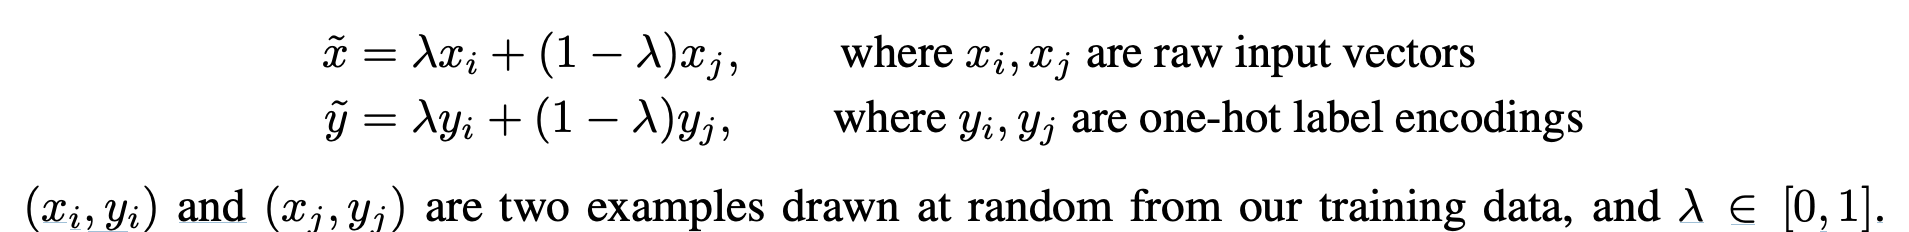

#### Αξιολόγηση του μοντέλου στο CIFAR-C

Για να καταλάβουμε περισσότερο τη χρησιμότητα του mixup και γενικότερα της επαύξησησς της κατανομής των δεδομένων εκπαίδευσης θα εκπαιδεύσουμε πάλι το μοντέλο μας στο CIFAR αλλά θα το κάνουμε evaluate στο CIFAR-C.

Το CIFAR-C παριέχει διάφορα corruptions (adversarial examples) στις εικόνες του αρχικού dataset, κάτι που το καθιστά πιο κοντά σε μια ρεαλιστική αξιολόγηση του μοντέλου.

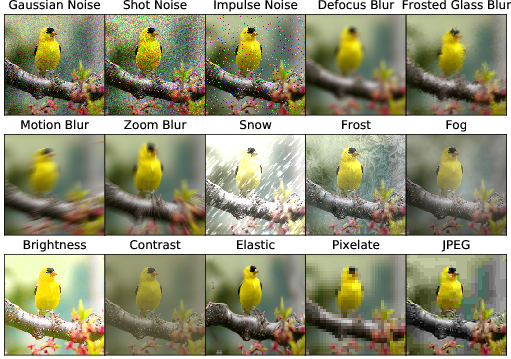


### Ζητούμενο 3 (3 μονάδες) 

*Σημείωση* 

- Στο παρακάτω κώδικα η υλοποίηση δεν είναι η επίσημη, γι'αυτό τα αποτελέσματα δεν είναι αντίστοιχα του ζητούμενου 1 και 2. 

- Επιπλέον, η διαφορά μεταξύ training με mixup και χωρίς mixup θα είναι πολύ μικρή ( μικρότερη απο 2%). 


#### Ζητούμενο 3α.
Κρατώντας τις παραμέτρους του δικτύου με τα καλύτερα αποτελέσματα (load best model από το ζητούμενο 1 και 2) θα κάνετε εκ νέου training με το custom Data Generator (CIFAR_Dataset) στο CIFAR και evaluation στο CIFAR-C χωρίς το mixup. 


#### Ζητούμενο 3b.
Eφαρμόστε τη μέθοδο mixup (συμπληρώστε τον κώδικα στο κελί με το CifarDataset) κάντε εκ νέου την εκπαίδευση και καταγράψτε τα αποτελέσματα 



In [ ]:
#### GRADED CELL ####

# Complete the following code and run the cell 


class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform, mixup):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.mixup = mixup

        # Loading all the data depending on whether the dataset is training or testing
        if self.train:
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format which PyTorch takes in the images
        # Original CIFAR format can be seen via its official page
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __get_mixup_rate__(self, con1=1.0, con2=1.0):
        from torch.distributions.beta import Beta
        return Beta(torch.tensor([con1]), torch.tensor([con2])).sample()

    def __mixup__(self, xi, xj, yi, yj):
        mixup_lambda = self.__get_mixup_rate__().item()
        mixed_up_image = mixup_lambda * xi + (1 - mixup_lambda) * xj
        mixed_up_label = mixup_lambda * yi + (1 - mixup_lambda) * yj

        return mixed_up_image, mixed_up_label


    def __getitem__(self, idx):

        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # Transform the image by converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and self.mixup and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            # label[self.targets[mixup_idx]] = 1.  # this is a bug in the code, it should be mixup_label. Fixing it
            mixup_label[self.targets[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(self.data[mixup_idx])

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            ### GRADED PART###

            image, label = self.__mixup__(image, mixup_image, label, mixup_label)
            

        return image, label

0.22897520661354065
Mixup label: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2290, 0.0000, 0.0000,
        0.7710])


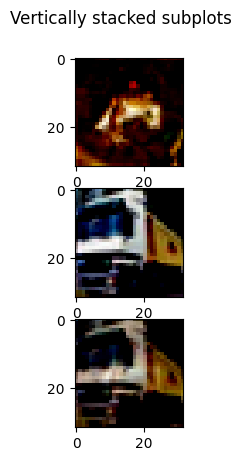

In [ ]:
# Test mix up code

def __get_mixup_rate__(con1=1.0, con2=1.0):
    from torch.distributions.beta import Beta
    return Beta(torch.tensor([con1]), torch.tensor([con2])).sample()

def __mixup_(xi, xj, yi, yj):
    mixup_lambda = __get_mixup_rate__().item()
    print(mixup_lambda)
    mixed_up_image = mixup_lambda * xi + (1 - mixup_lambda) * xj
    mixed_up_label = mixup_lambda * yi + (1 - mixup_lambda) * yj

    return mixed_up_image, mixed_up_label


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR_Dataset(f'{root_path}/data/cifar/cifar-10-batches-py/', 1, transform, False)

# imgplot = plt.imshow(myimage)

test_img, test_label = __mixup_(train_dataset[0][0], train_dataset[1][0], train_dataset[0][1], train_dataset[1][1])

print(f'Mixup label: {test_label}')

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
ax1.imshow(train_dataset[0][0].permute(1, 2, 0))
ax2.imshow(train_dataset[1][0].permute(1, 2, 0))
ax3.imshow(test_img.permute(1, 2, 0))

Παραπάνω βλέπουμε το αποτέλεσμα του MixUp.
Αρχικώς παίρνουμε δύο τυχαίες φωτογραφίες και τις συνθέτουμε με έναν συντελεστή ίσο με 0.2289, ο οποίος και προκύπτει από μία β-κατανομή. Το αποτέλεσμα αυτής της σύνθεσης φαίνεται στην τρίτη εικόνα του διαγράμματος.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

In [ ]:
# Evaluation scripts


def val_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            #targets = targets.cuda(non_blocking=True).long()
            #images = images.cuda(non_blocking=True).float()
            logits = net(images)
            pred = logits.data.max(1)[1]
            #total_correct += pred.eq(targets.data).sum().item()
            total_correct += int((pred == torch.argmax(targets, dim=1)).float().sum())
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_correct / len(test_loader.dataset)


def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = f'{root_path}/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(f'{root_path}/data/cifar/', train=False, transform=test_transform)
    
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))





In [ ]:
# Utils scripts

def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))


Ζητούμενο 3: βήμα 1

Κάντε train το καλύτερο μοντέλο που βρήκατε (και αποθηκεύσατε) στα βήματα 1 και 2 χωρίς το mixup

In [ ]:
num_epochs = 10 # we train for 10 epochs because of resources limitations

In [ ]:
#### GRADED CELL ####

# Κάντε train το καλύτερο μοντέλο που βρήκατε (και αποθηκεύσατε) στα βήματα 1 και 2 χωρίς το mixup

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391  # evaluation frequency (and log) (every epoch)

layers = 28  # total number of layers of wrn (wide residual network)
num_classes = 10  # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = .3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset(f'{root_path}/data/cifar/cifar-10-batches-py/', 1, transform, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset(f'{root_path}/data/cifar/cifar-10-batches-py/', 0, transform, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(1, num_iters + 1):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = bceloss(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}\n'.format(test_c_cifar(model)))
        epoch += 1

state_dict_best_No_mixUp = model.state_dict()

torch.save(state_dict_best_No_mixUp, f'{root_path}/WRN-best-no-MixUp.tar')

t =  391
Epoch  0
Validation set acc 0.4876
Weather
	 Test Acc 0.264
Blur
	 Test Acc 0.316
Noise
	 Test Acc 0.247
Digital
	 Test Acc 0.351
Average Cifar-C accuracy 0.2946345833333333

t =  782
Epoch  1
Validation set acc 0.5499
Weather
	 Test Acc 0.315
Blur
	 Test Acc 0.248
Noise
	 Test Acc 0.308
Digital
	 Test Acc 0.373
Average Cifar-C accuracy 0.31089041666666667

t =  1173
Epoch  2
Validation set acc 0.6206
Weather
	 Test Acc 0.392
Blur
	 Test Acc 0.373
Noise
	 Test Acc 0.211
Digital
	 Test Acc 0.471
Average Cifar-C accuracy 0.3616341666666667

t =  1564
Epoch  3
Validation set acc 0.6607
Weather
	 Test Acc 0.325
Blur
	 Test Acc 0.328
Noise
	 Test Acc 0.129
Digital
	 Test Acc 0.437
Average Cifar-C accuracy 0.30470375

t =  1955
Epoch  4
Validation set acc 0.7884
Weather
	 Test Acc 0.525
Blur
	 Test Acc 0.407
Noise
	 Test Acc 0.323
Digital
	 Test Acc 0.530
Average Cifar-C accuracy 0.4461104166666667

t =  2346
Epoch  5
Validation set acc 0.7635
Weather
	 Test Acc 0.538
Blur
	 Test Ac

In [ ]:
#### GRADED CELL #### 
# Train your best model with mixup and test on CIFAR-C

# Model parameters 


num_epochs = 10

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391  # evaluation frequency (and log) (every epoch) -- -1 because it's zero based

layers = 28  # total number of layers of wrn (wide residual network)
num_classes = 10  # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = .3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset(f'{root_path}/data/cifar/cifar-10-batches-py/', 1, transform, True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset(f'{root_path}/data/cifar/cifar-10-batches-py/', 0, transform, True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(1, num_iters + 1):  # range(1, num_iters + 1) so that we will print the accuracy scores for all epochs

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = bceloss(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}\n'.format(test_c_cifar(model)))
        epoch += 1

state_dict_best_mixUp = model.state_dict()
# print(state_dict_20_10)

torch.save(state_dict_best_mixUp, f'{root_path}/WRN-best-MixUp.tar')

t =  391
Epoch  0
Validation set acc 0.4321
Weather
	 Test Acc 0.252
Blur
	 Test Acc 0.286
Noise
	 Test Acc 0.249
Digital
	 Test Acc 0.303
Average Cifar-C accuracy 0.27280875

t =  782
Epoch  1
Validation set acc 0.5649
Weather
	 Test Acc 0.323
Blur
	 Test Acc 0.339
Noise
	 Test Acc 0.143
Digital
	 Test Acc 0.415
Average Cifar-C accuracy 0.30493750000000003

t =  1173
Epoch  2
Validation set acc 0.6846
Weather
	 Test Acc 0.452
Blur
	 Test Acc 0.340
Noise
	 Test Acc 0.342
Digital
	 Test Acc 0.481
Average Cifar-C accuracy 0.40365416666666665

t =  1564
Epoch  3
Validation set acc 0.6888
Weather
	 Test Acc 0.344
Blur
	 Test Acc 0.309
Noise
	 Test Acc 0.147
Digital
	 Test Acc 0.479
Average Cifar-C accuracy 0.31989208333333335

t =  1955
Epoch  4
Validation set acc 0.782
Weather
	 Test Acc 0.452
Blur
	 Test Acc 0.366
Noise
	 Test Acc 0.186
Digital
	 Test Acc 0.542
Average Cifar-C accuracy 0.38669

t =  2346
Epoch  5
Validation set acc 0.7634
Weather
	 Test Acc 0.509
Blur
	 Test Acc 0.398
No

### Σχολιασμός αποτελεσμάτων αξιολόγησης στο CIFAR-C dataset

Θα συγκρίνουμε και τα δύο μοντέλα (με ή χωρίς MixUp) βασει του καλύτερου validation set accuracy που επιτυγχάνουν και ανεξαρτήτου εποχής που το επιτυγχάνουν. Έτσι έχουμε:

#### Μοντέλο με χρήση του MixUp 
```
Epoch  7
Validation set acc 0.7855
Weather
	 Test Acc 0.608
Blur
	 Test Acc 0.500
Noise
	 Test Acc 0.390
Digital
	 Test Acc 0.501
Average Cifar-C accuracy 0.49998624999999997
```

#### Μοντέλο χωρίς την χρήση MixUp

```
Epoch  9
Validation set acc 0.8325
Weather
	 Test Acc 0.557
Blur
	 Test Acc 0.451
Noise
	 Test Acc 0.256
Digital
	 Test Acc 0.536
Average Cifar-C accuracy 0.45002458333333334
```

Παρατηρούμε ότι αν και το μοντέλο με MixUp έχει μικρότερο accuracy στο CIFAR-10 dataset σε σχέση με το μοντέλο χωρίς MixUp, παρ' όλα αυτά έχει καλύτερο accuracy στο CIFAR-C αποδεικνύοντας έτσι ότι το MixUp βοηθάει το μοντέλο να κάνει καλύτερο generalization σε dataset που δεν έχει "δει". Στο μοναδικό κομμάτι που το MixUp μοντέλο έχει ελαφρώς χειρότερη απόδοση είναι το *Digital Augmentation* του CIFAR-C.


Η προσφορά του MixUp στην συγκεκριμένη περίπτωση, αν και είναι κατανοητή δεν είναι οφθαλμοφανής. Το μοντέλο που χρησιμοποιεί την MixUp  τεχνική χρειάζεται παραπάνω εποχές εκπαίδευσης καθώς με 10 εποχές (περιορισμένοι πόροι στο Colab) το μοντέλο φαίνεται να εμφανίζει υψηλό bias.



### Ερώτημα 4 - Confidence scores

In [ ]:
layers = 28  # total number of layers of wrn (wide residual network)
num_classes = 10  # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = .3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005


mix_up_model = WideResNet(layers, num_classes, widen_factor, droprate)
simple_model = WideResNet(layers, num_classes, widen_factor, droprate)

mix_up_model.load_state_dict(torch.load(f'{root_path}/WRN-best-MixUp.tar'))
simple_model.load_state_dict(torch.load(f'{root_path}/WRN-best-no-MixUp.tar'))

mix_up_model.to(device)
simple_model.to(device)


normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
test_transform = transforms.Compose(
    [transforms.ToTensor(), normalize])
test_data = datasets.CIFAR10(f'{root_path}/data/cifar/', train=False, transform=test_transform)

In [ ]:
#### GRADED CELL #### (Bonus)

# Plot the confidence scores for CIFAR-C with WRN model 
# trained with and without mixup and comment


def model_score(model, test_loader):
  model.eval()
  params = list(model.parameters())
  total_loss = 0.
  total_correct = 0
  tp_prob_list = []
  tp_label_list = []
  with torch.no_grad():
      for images, targets in test_loader:
          images = images.to(device)
          targets = targets.to(device)
          logits = model(images)
          preds = nn.Softmax(dim=1)(logits)
          pred = preds.data.max(1)[1]  # get label from softmax with largest probability
          mask = pred.eq(targets.data)  # create mask to keep only the TP predictions
          tp_probs = preds[mask].data.max(1)[0]  # get softmax probs for TP
          tp_labels = preds[mask].data.max(1)[1]  # get softmax labels for TP
          tp_prob_list += list(tp_probs.cpu().detach().numpy())
          tp_label_list += list(tp_labels.cpu().detach().numpy())

  return tp_prob_list, tp_label_list
  


def get_confidence_scores(model, test_data):
  corruption_accs = []
  Weather_accs = []
  Blur_accs = []
  Noise_accs = []
  Digital_accs = []
  weather_corr = ['snow', 'frost', 'fog']
  blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
  noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
  digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

  base_path = f'{root_path}/data/cifar/CIFAR-10-C/'

  score_list = []
  for corruption in CORRUPTIONS:
      # Reference to original data is mutated
      test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
      test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

      test_loader = torch.utils.data.DataLoader(
          test_data,
          batch_size=batch_size,
          shuffle=False,
          #num_workers=4,
          pin_memory=True)
      
      local_score_list, local_label_list = model_score(model, test_loader)
      score_list += local_score_list

  return score_list


In [ ]:
def plot_confidence_scores(xval, yval, xlabel, ylabel, title):
  fig = plt.figure()
  plt.yticks(np.arange(0, 1800, 100))
  plt.bar(xval, yval, color ='blue', width = 0.4)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

def plot_histogram_of_confidence_scores(x, xlabel, ylabel, title):
  plt.hist(x, bins=20)
  plt.xticks(np.arange(0,101,5))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [ ]:
mixup_confidence_scores = get_confidence_scores(mix_up_model, test_data)

import pickle

with open(f'{root_path}/mixup_confidence_scores.pkl', 'wb') as f:
  pickle.dump(mixup_confidence_scores, f)

NameError: ignored

In [ ]:
with open(f'{root_path}/mixup_confidence_scores.pkl', 'rb') as f:
  mixup_confidence_scores_plk = pickle.load(f)

mixup_confidence_scores_plk_perc_rnd = [round(x * 100, 1) for x in mixup_confidence_scores_plk]

In [ ]:
print(mixup_confidence_scores_plk_perc_rnd)

[34.6, 98.0, 99.1, 97.9, 98.9, 97.8, 49.8, 75.2, 99.8, 86.2, 99.7, 93.8, 53.9, 87.6, 99.9, 99.6, 80.0, 51.8, 92.9, 39.1, 96.7, 99.6, 82.8, 98.7, 98.2, 96.0, 92.1, 44.7, 37.5, 56.8, 99.4, 52.7, 95.2, 55.2, 83.3, 99.7, 72.9, 98.8, 49.6, 95.7, 82.0, 53.4, 83.1, 85.2, 30.5, 72.0, 50.3, 97.1, 29.1, 90.9, 27.2, 96.3, 94.2, 50.8, 67.9, 98.9, 73.6, 52.1, 39.1, 86.7, 99.0, 89.1, 56.7, 88.9, 95.5, 92.3, 99.3, 75.4, 39.5, 64.4, 53.6, 99.9, 39.1, 55.2, 93.7, 76.9, 93.5, 50.8, 99.7, 58.3, 88.0, 66.4, 99.8, 99.8, 98.5, 91.0, 37.9, 36.5, 92.7, 99.9, 49.7, 99.6, 99.9, 97.4, 78.6, 88.9, 77.8, 79.4, 91.0, 44.8, 87.5, 71.8, 83.6, 94.5, 99.6, 95.6, 71.5, 66.4, 81.7, 60.4, 99.5, 99.4, 48.3, 94.5, 78.0, 99.1, 49.9, 99.7, 97.0, 98.7, 87.3, 73.2, 45.9, 97.5, 83.2, 98.6, 91.2, 99.9, 59.9, 82.4, 98.0, 94.4, 92.5, 31.3, 99.0, 99.9, 93.4, 82.0, 86.6, 77.5, 99.3, 98.4, 99.9, 99.9, 99.4, 99.8, 49.6, 73.3, 99.0, 99.6, 45.7, 98.5, 94.0, 95.9, 99.1, 47.8, 90.3, 99.6, 97.9, 83.2, 88.3, 99.5, 33.1, 81.4, 97.3, 94.8, 42.

In [ ]:
simple_confidence_scores = get_confidence_scores(simple_model, test_data)

import pickle

with open(f'{root_path}/simple_confidence_scores.pkl', 'wb') as f:
  pickle.dump(simple_confidence_scores, f)

In [ ]:
with open(f'{root_path}/simple_confidence_scores.pkl', 'rb') as f:
  simple_confidence_scores_pkl = pickle.load(f)

simple_confidence_scores_plk_perc_rnd = [round(x * 100, 1) for x in simple_confidence_scores_pkl]

In [ ]:
import collections

freq_mixup = collections.Counter(mixup_confidence_scores_plk_perc_rnd)

freq_simple = collections.Counter(simple_confidence_scores_plk_perc_rnd)

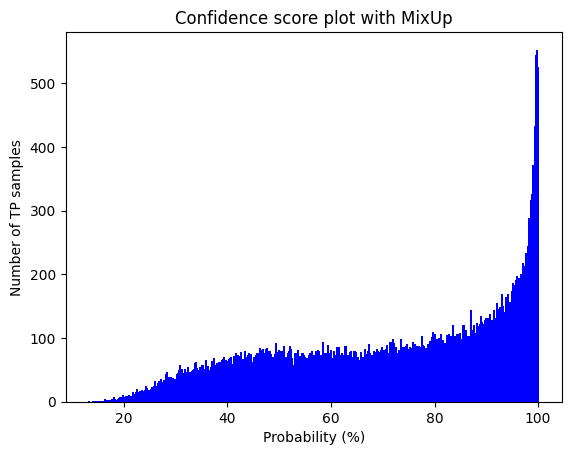

In [ ]:
plot_confidence_scores(list(freq_mixup.keys()), list(freq_mixup.values()), 'Probability (%)', 'Number of TP samples', 'Confidence score plot with MixUp')

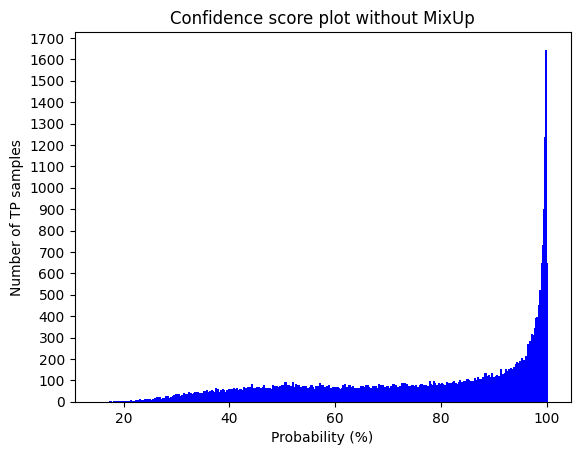

In [ ]:
plot_confidence_scores(list(freq_simple.keys()), list(freq_simple.values()), 'Probability (%)', 'Number of TP samples', 'Confidence score plot without MixUp')

In [ ]:
print(f'Total number of TP with MixUp: {sum(freq_mixup.values())}')
print(f'Total number of TP without MixUp: {sum(freq_simple.values())}')

Total number of TP with MixUp: 66041
Total number of TP without MixUp: 69238


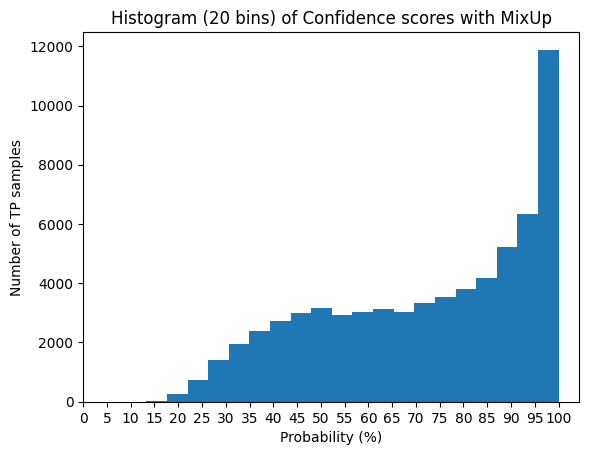

In [ ]:
plot_histogram_of_confidence_scores(mixup_confidence_scores_plk_perc_rnd, 'Probability (%)', 'Number of TP samples', 'Histogram (20 bins) of Confidence scores with MixUp')

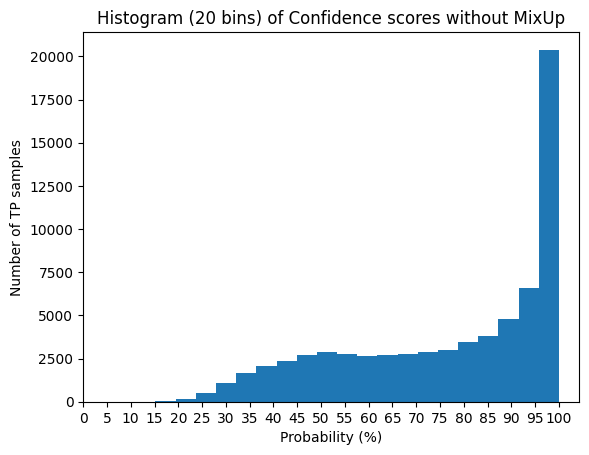

In [ ]:
plot_histogram_of_confidence_scores(simple_confidence_scores_plk_perc_rnd, 'Probability (%)', 'Number of TP samples', 'Histogram (20 bins) of Confidence scores without MixUp')

### Σχολιασμός Confidence score plot

Παρατηρούμε ότι τα confidence score plots και για τα δύο μοντέλα είναι left-skewed προς τις τιμές των πιθανοτήτων που προσεγγίζουν το 1 (ή 100%). Αυτό δείχνει ότι ο ταξινομητής μας (classifier) ταξινομεί τα TP δείγματα με μία αρκούντως καλή σιγουριά. 

Το accuracy score για το μοντέλο με MixUp είναι καλύτερο από αυτό χωρίς MixUp αλλά ο αριθμός των TΡ δειγμάτων είναι μικρότερος. Αυτό σημαίνει ότι ο MixUp classifier έχει ταξινομήσει καλύτερα τα TN δείγματα σε σχέση με τον no-MixUp classifier.


Μιας και τα bar plots των confidence scores είναι δύσκολο να συγκριθούν μεταξύ τους, αποφασίσαμε να εκτυπώσουμε το ιστόγραμμα των confidence scores χρησιμοποιώντας 20 bins.